In [117]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from pprint import pprint
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# IMPORTANT: RUN THESE 3 LINES ONCE TO DOWNLOAD NECESSARY PACKAGES
# ================================================================
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# ================================================================

def cleanSentence(review):
	"""clean review of the line breaks

	Args:
			review (string): review

	Returns:
			string: cleaned reivew
	"""
	return re.sub(r'<br /><br />', '', review)

def extractSentence(review):
	"""extract number of sentence from input review

	Args:
			review (string): input review

	Returns:
			number: number of sentence in the input review
	"""
	pattern = r'\."?\s"?[A-Z]'
	sentences = len(re.findall(pattern, review))
	return sentences

def LoS2DoL(LoS):
	"""convert list of set (word, pos) to dict of list {pos:[words]}

	Args:
			LoS (list of set): input list of set to be converted

	Returns:
			dict of list: dictionary keyed by pos, valued by list of words that has the pos
	"""
	d = {}
	for s in LoS:
		word, pos = s
		if pos in d:
			d[pos].append(word)
		else:
			d[pos] = [word]
	return d

def mergeDoL(DoLs):
	"""merge multiple dict of list into one dict of list, inclusive of all keys

	Args:
			DoLs (list of DoL): input DoLs to be merged

	Returns:
			DoL: a unified dict of list
	"""
	d = {}
	for DoL in DoLs:
		for key in DoL:
			if key in d:
				d[key].extend(DoL[key])
			else:
				d[key] = DoL[key]
	return d

def POStag(review):
	"""tag the review with its pos

	Args:
			review (DoL): dictionary of list, keyed by the pos, valued by list of words
	
	Returns:
			DoL of entire review, keyed by pos, valued by list of words that has the pos.
	"""
	stop_words = set(stopwords.words('english'))
	sentences = sent_tokenize(review)
	DoLsTagged = []
	for sentence in sentences:
		# Word tokenizers is used to find the words and punctuation in a string
		wordsList = nltk.word_tokenize(sentence)
		# removing stop words from wordList
		wordsList = [w for w in wordsList if not w in stop_words] 
		#  Using a Tagger. Which is part-of-speech tagger or POS-tagger. 
		tagged = nltk.pos_tag(wordsList)
		DoLtagged = LoS2DoL(tagged)
		DoLsTagged.append(DoLtagged)
	return mergeDoL(DoLsTagged)


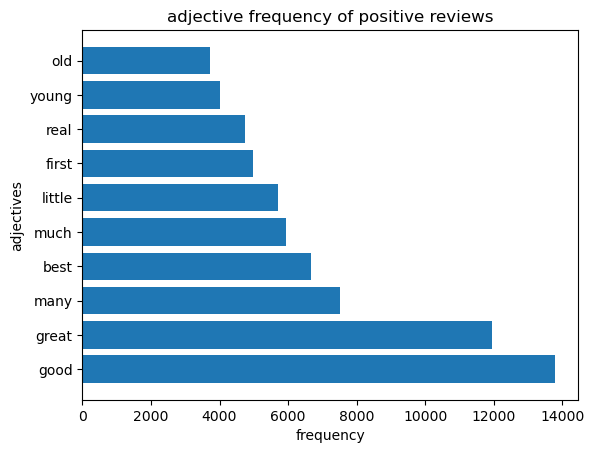

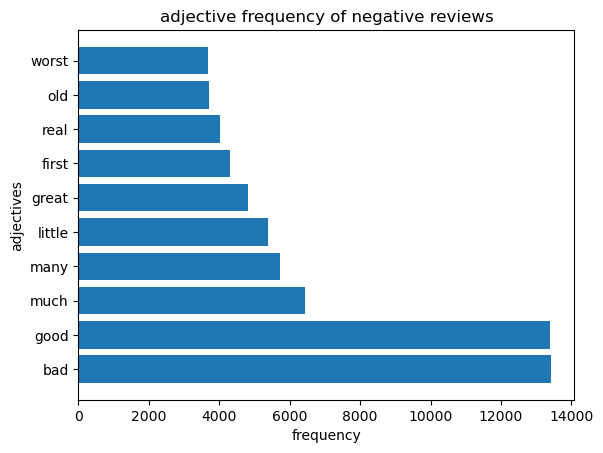

In [126]:
def parseTextToCSV(filepath, filename, csv, separator):
	"""parse input txt file, run analysis, then write to input csv file

	Args:
			filepath (string): path to txt file
			filename (string): name of txt file
			csv (file object): file object to write analysis to
			separator (string): string pattern to separate values
	"""
	with open(filepath + filename, 'r') as txtFile:
		review = txtFile.readline()
		review = cleanSentence(review)
		csv.write(review + separator)
		sentences = extractSentence(review)	
		csv.write(str(sentences) + separator)
		pos = POStag(review)
		adjs = []
		# JJ: normal adjective (big)
		# JJR: comparative adjective (bigger)
		# JJS: superlative adjective (biggest)
		adjTag = ["JJ", "JJR", "JJS"]
		for tag in adjTag:
			if tag in pos:
				adjs.extend(pos[tag])
		csv.write(','.join(adjs))
		csv.write('\n')

def csv2df(csvName, separator):
	"""convert csv to pandas dataframe

	Args:
			csvName (string): name of csv file to be converted

	Returns:
			pandas.DataFrame: converted DataFrame
	"""
	df = pd.DataFrame()
	with open(csvName, 'r') as f:
		columns = f.readline().strip().split(separator)
		LoL = []
		for line in f:
			LoL.append(line.strip().split(separator))
		df = pd.DataFrame(LoL, columns=columns)
		df = df.dropna()
	return df

def extractFreq(df):
	"""extract frequency dictionary from input df

	Args:
			df (DataFrame): input dataframe to be extract

	Returns:
			dict: adjective frequency dictionary of input dataframe
	"""
	d = {}
	adjsRows = list(df['adjectives'])
	for adjsRow in adjsRows:
		adjs = adjsRow.split(',')
		adjs = [adj.lower() for adj in adjs]
		for adj in adjs:
			if adj in d:
				d[adj] = d[adj] + 1
			else:
				d[adj] = 1
	return d

def main():
	columns = ['review', 'sentences', 'adjectives']
	separator = " | "
	posDict = {}
	negDict = {}

	# parse positive reviews to csv files
	if not os.path.exists('pos.csv'):
		with open('pos.csv', 'w') as csv:
			csv.write(separator.join(columns))
			csv.write('\n')
			for filename in os.listdir('./dataset/test/pos/'):
				parseTextToCSV('./dataset/test/pos/', filename, csv, separator)
			for filename in os.listdir('./dataset/train/pos/'):
				parseTextToCSV('./dataset/train/pos/', filename, csv, separator)

	# parse negative reviews to csv files
	if not os.path.exists('neg.csv'):
		with open('neg.csv', 'w') as csv:
			csv.write(separator.join(columns))
			csv.write('\n')
			for filename in os.listdir('./dataset/test/neg/'):
				parseTextToCSV('./dataset/test/neg/', filename, csv, separator)
			for filename in os.listdir('./dataset/train/neg/'):
				parseTextToCSV('./dataset/train/neg/', filename, csv, separator)

	# convert positive csv file to pandas Data frame
	if os.path.exists('pos.csv'):
		posDF = csv2df('pos.csv', separator)
		posDict = extractFreq(posDF)


	if os.path.exists('neg.csv'):
		negDF = csv2df('neg.csv', separator)
		negDict = extractFreq(negDF)

	# plot for positive reviews
	topPosAdj = sorted(posDict.items(), key=lambda x: x[1], reverse=True)[:10]
	posWords = []
	posFreqs = []
	for word, freq in topPosAdj:
		posWords.append(word)
		posFreqs.append(freq)

	plt.barh(posWords, posFreqs)
	plt.title('adjective frequency of positive reviews')
	plt.ylabel('adjectives')
	plt.xlabel('frequency')
	plt.show()

	# plot for positive reviews
	topNegAdj = sorted(negDict.items(), key=lambda x: x[1], reverse=True)[:10]
	negWords = []
	negFreqs = []
	for word, freq in topNegAdj:
		negWords.append(word)
		negFreqs.append(freq)

	plt.barh(negWords, negFreqs)
	plt.title('adjective frequency of negative reviews')
	plt.ylabel('adjectives')
	plt.xlabel('frequency')
	plt.show()



	




	



main()